In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne

from invert.forward import get_info, create_forward_model
from invert.util import pos_from_forward
pp = dict(surface='inflated', hemi='both', clim=dict(kind="percent", pos_lims=(0, 99, 100)), colorbar=False, verbose=0)

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')
pos = pos_from_forward(fwd)
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape
source_model = fwd['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    3.8s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


# Simulate

In [23]:
from invert.solvers.esinet import generator

sim_params = dict(
    use_cov=False, 
    return_mask=False, 
    batch_repetitions=1,
    batch_size=1,
    n_sources=1, 
    n_orders=(2, 3), 
    snr_range=(100, 101), 
    n_timecourses=1,
    scale_data=False)
    

gen = generator(fwd, **sim_params)
x, y = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)


In [30]:
brain = stc.plot(**pp, brain_kwargs=dict(title="Ground Truth"))
brain.add_text(0.1, 0.9, "Ground Truth", 'title', font_size=16)

ValueError: Neither input subject subject nor class subject attribute was a string

In [27]:
# evoked.save("../figures/solver_gallery/evoked-ave.fif")
stc.save("../figures/solver_gallery/source")

Writing STC to disk...
[done]


# Load Evoked

In [3]:
evoked = mne.read_evokeds("../figures/solver_gallery/evoked-ave.fif")[0]
stc = mne.read_source_estimate("../figures/solver_gallery/source-lh.stc")

Reading c:\Users\Lukas\Documents\projects\invert\dev\..\figures\solver_gallery\evoked-ave.fif ...
    Found the data of interest:
        t =       0.00 ...      19.00 ms (No comment)
        0 CTF compensation matrices available
        nave = 1 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline correction applied


# Plot Ground Truth and Inverse Solutions

In [6]:
all_solvers[15]

'MM Champagne'

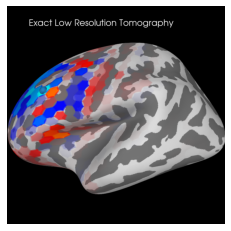

In [14]:
%matplotlib inline
from invert import Solver
from invert.config import all_solvers

# Plot Ground Truth
stc.data /= abs(stc.data[:, 0]).max()
clim = dict(kind="values", pos_lims=(0., 0.5, 1))
pp["clim"] = clim
brain = stc.plot(**pp, subject="fsaverage", brain_kwargs=dict(title="Ground Truth"))
brain.add_text(0.1, 0.9, "Ground Truth", 'title', font_size=16)
img = brain.screenshot()
brain.close()

plt.figure()
plt.imshow(img)
plt.axis("off")
fname = f"../figures/solver_gallery/GroundTruth"
plt.savefig(fname, dpi=150)
plt.close()
all_solvers = ["sloreta",]
# Plot Source Estimates
for solver_name in all_solvers:
    solver = Solver(solver_name)
    solver.make_inverse_operator(fwd, evoked)
    stc_ = solver.apply_inverse_operator(evoked)
    stc_.data /= abs(stc_.data[:, 0]).max()
    clim = dict(kind="values", pos_lims=(0., 0.5, 1))
    pp["clim"] = clim
    brain = stc_.plot(**pp, subject="fsaverage", brain_kwargs=dict(title=solver.name))
    brain.add_text(0.1, 0.9, solver.name, 'title', font_size=16)
    img = brain.screenshot()
    brain.close()
    
    fig = plt.figure()
    plt.imshow(img)
    plt.axis("off")

    fname = f"""../figures/solver_gallery/{solver.name.replace(" ", "")}"""
    plt.savefig(fname, dpi=150)
    plt.close()

# Solve

In [ ]:
# from invert import Solver
# solver = Solver("lstm")
# solver.make_inverse_operator(fwd, evoked, alpha="auto")
stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print("r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])
print("L1 = ",  np.linalg.norm(stc_.data, ord=1))

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
r =  0.19636086828602
L1 =  20.113617


Using control points [0.0476362  0.05874738 0.41511153]
Using control points [0.0476362  0.05874738 0.41511153]
Using control points [0.0476362  0.05874738 0.41511153]
Using control points [0.0476362  0.05874738 0.41511153]
Using control points [0.01255137 0.10915932 0.70373472]
Using control points [0.01255137 0.10915932 0.70373472]
Using control points [0.02688973 0.03550795 0.22265582]
Using control points [0.01029644 0.04761037 0.63900793]
Using control points [0.02688973 0.03550795 0.22265582]
